## U-Net for Image Segmentation with JAX

This Colab notebook guides you through building and training a U-Net architecture using JAX for image segmentation tasks, emphasizing the use of `jax.jit` for performance optimization.

**Understanding U-Net Architecture**

U-Net is a convolutional neural network architecture specifically designed for image segmentation. Its unique U-shaped structure allows it to excel at capturing both local details (fine-grained features) and contextual information  (the broader picture) within an image.  Here's how it works:

* **Contracting Path (Encoder):**
    * Consists of multiple down-convolution blocks. Each block applies a series of convolutional layers followed by an activation function (e.g., ReLU).
    * Down-convolution layers, often with pooling operations (like max pooling), progressively reduce the spatial resolution of the input image while increasing the channels (feature maps). These extracted features become increasingly complex and high-level.

* **Expansive Path (Decoder):**
    * Composed of up-convolution blocks that utilize transposed convolutions to increase spatial resolution while decreasing channel depth.
    * Each block upsamples the feature maps, combining them with skip connections from the corresponding level in the contracting path.
    * Skip connections concatenate higher-resolution feature maps from the encoder with the expanded feature maps from the decoder. This helps recover precise localization details lost during downsampling.

* **Output Layer:**
    * A final convolutional layer, often with a sigmoid activation function, generates the segmentation output(s). This output typically  has the same dimensions as the input image.

**The benefits of this architecture make U-Net highly effective for various image segmentation tasks.**

**1. Setting Up and Importing Libraries**

In [78]:
# ! pip install jax jaxlib scikit-learn opencv-python matplotlib flax -q

In [79]:
import jax
import jax.numpy as jnp
from jax import random

# Additional libraries you might need based on your dataset (e.g., for loading and preprocessing)
# ...
import haiku as hk
import jax.nn
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from flax import linen as nn
from typing import Callable


**2. Defining the U-Net Architecture**

In [99]:

# @jax.jit
def conv_layer(inputs, filters, kernel_size, padding='SAME'):
  """
  Defines a single convolutional layer with ReLU activation and batch normalization.

  Args:
    inputs: Input tensor (e.g., image data).
    filters: Number of filters in the convolutional layer.
    kernel_size: Size of the convolutional kernel.
    padding: Padding strategy for the convolution ('same' or 'valid').

  Returns:
    Output tensor after applying convolution, ReLU activation, and batch normalization.
  """
  # Apply convolution
  conv = nn.Conv(features=filters, kernel_size=kernel_size,padding=padding)(inputs)

  # print(f"Feature shape:{filters}")
  # print(f"Kernel shape:{kernel_size}")

  # Apply ReLU activation (optional)
  activated = nn.relu(conv)

  # Apply batch normalization (optional)
  normalized = nn.BatchNorm(use_running_average=True, momentum=0.999, epsilon=1e-5)(activated)

  return normalized

# @jax.jit
def conv_block(inputs, filters, kernel_size):
  """Defines a convolutional block with activation and normalization (jitted)."""
  # ... implement convolutional layers, ReLU activation, and batch normalization

  conv1 = conv_layer(inputs, filters, kernel_size)
  # print(f"conv1{conv1.shape}")
  conv2 = conv_layer(conv1, filters, kernel_size)
  # print(f"conv2{conv2.shape}")
  output = conv2

  return output

# @jax.jit
def encoder_block(inputs, filters, kernel_size):
  """Defines an encoder block with downsampling and skip connection (jitted)."""
  # ... apply two convolutional blocks
  conv = conv_block(inputs, filters, kernel_size)
  skip_connection = conv

  down_sampled = nn.max_pool(conv, window_shape=(2, 2), strides=(2, 2), padding='SAME')  # apply max pooling for downsampling

  return down_sampled, skip_connection

# @jax.jit
def decoder_block(inputs, skip_connection, filters, kernel_size):
  """Defines a decoder block with upsampling and skip connection (jitted)."""
  # Apply transposed convolution for upsampling
  t_conv = nn.ConvTranspose(features=filters, kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='SAME')(inputs)
  # print(f"Shape of t_conv {t_conv.shape}")

  # Ensure t_conv and skip_connection have the same shape
  t_conv = t_conv[:skip_connection.shape[0], :, :] # Adjust the shape of t_conv to match that of skip_connection
  
  # Concatenate with skip connection from encoder
  concatenated = jnp.concatenate([t_conv, skip_connection], axis=-1)
  
  # Apply two conv blocks and return
  out = conv_block(concatenated, filters, kernel_size)
  outputs = conv_block(out, filters, kernel_size)

  return outputs

# @jax.jit
def unet(inputs, filters, kernel_size):
  """Defines the U-Net architecture (jitted)."""
  # ... create encoder blocks with increasing filter depth
  # Encoder
  enc1, skip1 = encoder_block(inputs, filters, kernel_size)
  # print(f"Shape of skip1 {skip1.shape}")
  # print(f"Shape of enc1 {enc1.shape}")
  enc2, skip2 = encoder_block(enc1, filters*2, kernel_size)
  # print(f"Shape of skip2 {skip2.shape}")
  # print(f"Shape of enc3 {enc2.shape}")
  enc3, skip3 = encoder_block(enc2, filters*4, kernel_size)
  # print(f"Shape of skip3 {skip3.shape}")
  # print(f"Shape of enc3 {enc3.shape}")
  enc4, skip4 = encoder_block(enc3, filters*8, kernel_size)
  # print(f"Shape of skip4 {skip4.shape}")
  # print(f"Shape of enc4 {enc4.shape}")

  # Bottom
  bottom = conv_block(enc4, filters*8, kernel_size)

  # print(f"Shape of bottom {bottom.shape}")

  # ... create decoder blocks with decreasing filter depth
  # Decoder
  dec1 = decoder_block(bottom, skip4, filters*8, kernel_size)
  dec2 = decoder_block(dec1, skip3, filters*4, kernel_size)
  dec3 = decoder_block(dec2, skip2, filters*2, kernel_size)
  dec4 = decoder_block(dec3, skip1, filters, kernel_size)

  # ... apply final convolution for regression output (e.g., 4 channels for tumor segmentation)
  outputs = conv_layer(dec4, 4, 1)

  return outputs

**3. Data Acquisition and Preprocessing:**

* Download the BraTS 2020 dataset from [https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation).
* Preprocess the data by:
    * Resizing images to a fixed size suitable for your model.
    * Normalizing pixel intensities (e.g., scaling between 0 and 1).
    * Segmenting the brain region using provided masks if necessary.
    * Splitting the data into training, validation, and test sets.


In [100]:
def load_data(image_folder):
    image_paths = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.tif')])

    images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths]

    return jnp.array(images)

In [101]:
def preprocess_images(images):

    images = np.array(images)

    # print(f"Images shape: {images[0].shape}")
  
    # Resize images to a fixed size suitable for your model
    resized_images = [cv2.resize(img, (256, 256)) for img in images]
    # Normalize pixel intensities (scaling between 0 and 1)
    normalized_images = [img / 255.0 for img in resized_images]
    return jnp.array(normalized_images)

In [83]:
# Load your image segmentation dataset (modify accordingly)
# ...
image_folder = "Brain_Tumour/Dataset/images"
mask_folder = "Brain_Tumour/Dataset/masks"

# Load data
images = load_data(image_folder)
masks = load_data(mask_folder)

# Preprocess data
processed_images = preprocess_images(images)
processed_masks = preprocess_images(masks)

# Preprocess data (normalize and resize). Then split into train, test and validation:

# Split into train and validation:
train_images, test_images, train_masks, test_masks = train_test_split(processed_images,
                                                                    processed_masks,
                                                                    test_size=0.2,
                                                                    random_state=42)

# If you want to further split the training set into training and testing sets, you can do so like this:
train_images, val_images, train_masks, val_masks = train_test_split(train_images,
                                                                      train_masks,
                                                                      test_size=0.2,
                                                                      random_state=42)

# Print sizes of train and test sets
print(f"Train images size: {train_images.shape}")
print(f"Validation images size: {val_images.shape}")
print(f"Test images size: {test_images.shape}")
print(f"Train masks size: {train_masks.shape}")
print(f"Validation masks size: {val_masks.shape}")
print(f"Test masks size: {test_masks.shape}")
print(f"Image size: {test_images[0].shape}")
print(f"Mask size: {test_masks[0].shape}")


Images shape: (256, 256)
Images shape: (256, 256)
Train images size: (2514, 256, 256)
Validation images size: (629, 256, 256)
Test images size: (786, 256, 256)
Train masks size: (2514, 256, 256)
Validation masks size: (629, 256, 256)
Test masks size: (786, 256, 256)
Image size: (256, 256)
Mask size: (256, 256)


**4. Model Training**

In [102]:
class UNet(nn.Module):
    filters: int
    kernel_size: int
    unet: Callable

    def __post_init__(self):
        self.filters = filters
        self.kernel_size = kernel_size
        self.unet = unet
        super().__post_init__()
    
    @nn.compact
    def __call__(self, x):
        x = self.unet(x, self.filters, self.kernel_size)
        # Ensure the output has the same number of channels as the masks
        x = nn.Conv(256, kernel_size=self.kernel_size)(x)
        return x


In [103]:
# Hyperparameters
learning_rate = 0.001
epochs = 50

# Initialize model parameters
key = random.PRNGKey(0)

input_shape = 256

# Define filters and kernel_size
filters = 64
kernel_size = 3

# Initialize the model
unet_model = UNet(filters=filters, kernel_size=kernel_size, unet=unet)
params = unet_model.init(key, jnp.zeros((input_shape, input_shape, 256), jnp.float32))


In [104]:
def loss_fn(params, images, masks):
    logits = unet_model.apply(params, images)
    return jnp.mean((logits - masks)**2)


In [105]:
# Define the training step function
@jax.jit
def train_step(params, images, masks):
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(params, images, masks)
    updated_params = {
        key: {
            sub_key: {
                sub_sub_key: params[key][sub_key][sub_sub_key] - learning_rate * grads[key][sub_key][sub_sub_key]
                for sub_sub_key in params[key][sub_key]
            } for sub_key in params[key]
        } for key in params
    }
    return updated_params

Epoch 0, Step 0, Loss: 0.009579770267009735
Epoch 0, Step 160, Loss: 0.011997275054454803
Epoch 0, Step 320, Loss: 0.00581735372543335
Epoch 0, Step 480, Loss: 0.00677507184445858
Epoch 0, Step 640, Loss: 0.008626893162727356
Epoch 0, Step 800, Loss: 0.008364694193005562
Epoch 0, Step 960, Loss: 0.010799839161336422
Epoch 0, Step 1120, Loss: 0.007923422381281853
Epoch 0, Step 1280, Loss: 0.012069091200828552
Epoch 0, Step 1440, Loss: 0.007128383498638868
Epoch 0, Step 1600, Loss: 0.00826997123658657
Epoch 0, Step 1760, Loss: 0.010773354209959507
Epoch 0, Step 1920, Loss: 0.0062640151008963585
Epoch 0, Step 2080, Loss: 0.01108644064515829
Epoch 0, Step 2240, Loss: 0.01330307312309742
Epoch 0, Step 2400, Loss: 0.005931503605097532
Epoch 1, Step 0, Loss: 0.00957902055233717
Epoch 1, Step 160, Loss: 0.011996441520750523
Epoch 1, Step 320, Loss: 0.005816906224936247
Epoch 1, Step 480, Loss: 0.0067745293490588665
Epoch 1, Step 640, Loss: 0.008626123890280724
Epoch 1, Step 800, Loss: 0.008364

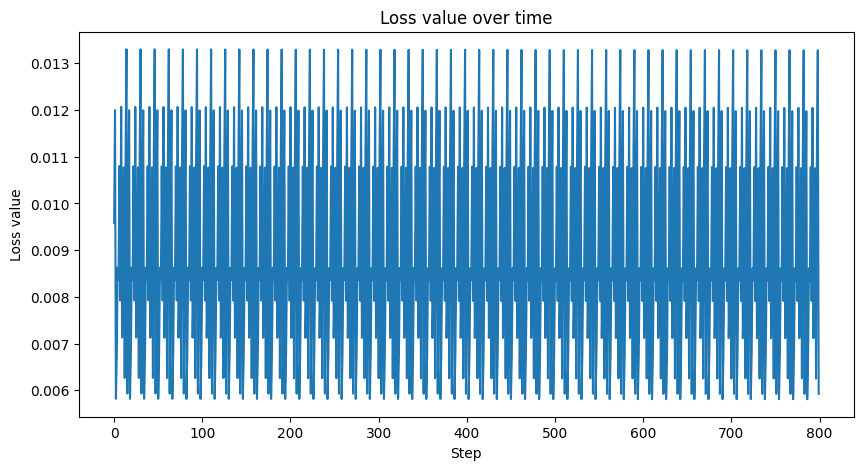

In [107]:
# Training loop
rng = jax.random.PRNGKey(0)
loss_values = []  # Store loss values

for epoch in range(epochs):
    for i in range(0, len(train_images), 32):
        batch_images = train_images[i:i+32]
        batch_masks = train_masks[i:i+32]

        params = train_step(params, batch_images, batch_masks)
        if i % 10 == 0:
            loss_value = loss_fn(params, batch_images, batch_masks)
            loss_values.append(loss_value)  # Append current loss value
            print(f"Epoch {epoch}, Step {i}, Loss: {loss_value}")

print("Training completed!")

# Plotting the loss values
plt.figure(figsize=(10, 5))
plt.plot(loss_values)
plt.title('Loss value over time')
plt.xlabel('Step')
plt.ylabel('Loss value')
plt.show()

**5. Model Evaluation**

In [108]:
@jax.jit
def dice_coefficient(pred, target):
    """Compute Dice coefficient."""
    intersection = jnp.sum(pred * target)
    union = jnp.sum(pred) + jnp.sum(target)
    return (2. * intersection) / (union + 1e-7)

In [109]:
@jax.jit
def jaccard_index(pred, target):
    """Compute Jaccard index."""
    intersection = jnp.sum(pred * target)
    union = jnp.sum(pred) + jnp.sum(target) - intersection
    return (intersection) / (union + 1e-7)

In [133]:
@jax.jit
def evaluate(params, images, masks):
  """Evaluation with jitted metric calculation (jitted)."""
  logits = unet_model.apply(params, images)

  print({logits})
  print("---------------------------")
  print({masks})
  # Convert logits to binary predictions
  predictions = jnp.argmax(logits, axis=-1)

  # Compute metrics for each segmentation channel
  dice_scores = jnp.array([dice_coefficient(predictions == i, masks == i) for i in range(4)])
  jaccard_scores = jnp.array([jaccard_index(predictions == i, masks == i) for i in range(4)])
  # dice_scores = jnp.array([dice_coefficient(logits == i, masks == i) for i in range(4)])
  # jaccard_scores = jnp.array([jaccard_index(logits == i, masks == i) for i in range(4)])

  return dice_scores, jaccard_scores

In [134]:
dice_scores, jaccard_scores = evaluate(params, val_images, val_masks)
print(f"Dice Score: {dice_scores} \n Jaccard Score: {jaccard_scores}")

{Traced<ShapedArray(float32[629,256,256])>with<DynamicJaxprTrace(level=1/0)>}
---------------------------
{Traced<ShapedArray(float32[629,256,256])>with<DynamicJaxprTrace(level=1/0)>}


ValueError: Incompatible shapes for broadcasting: shapes=[(629, 256), (629, 256, 256)]

In [128]:
# Visualization function
def visualize_results(images, masks, predictions, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 15))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.show()

TypeError: Invalid shape (256,) for image data

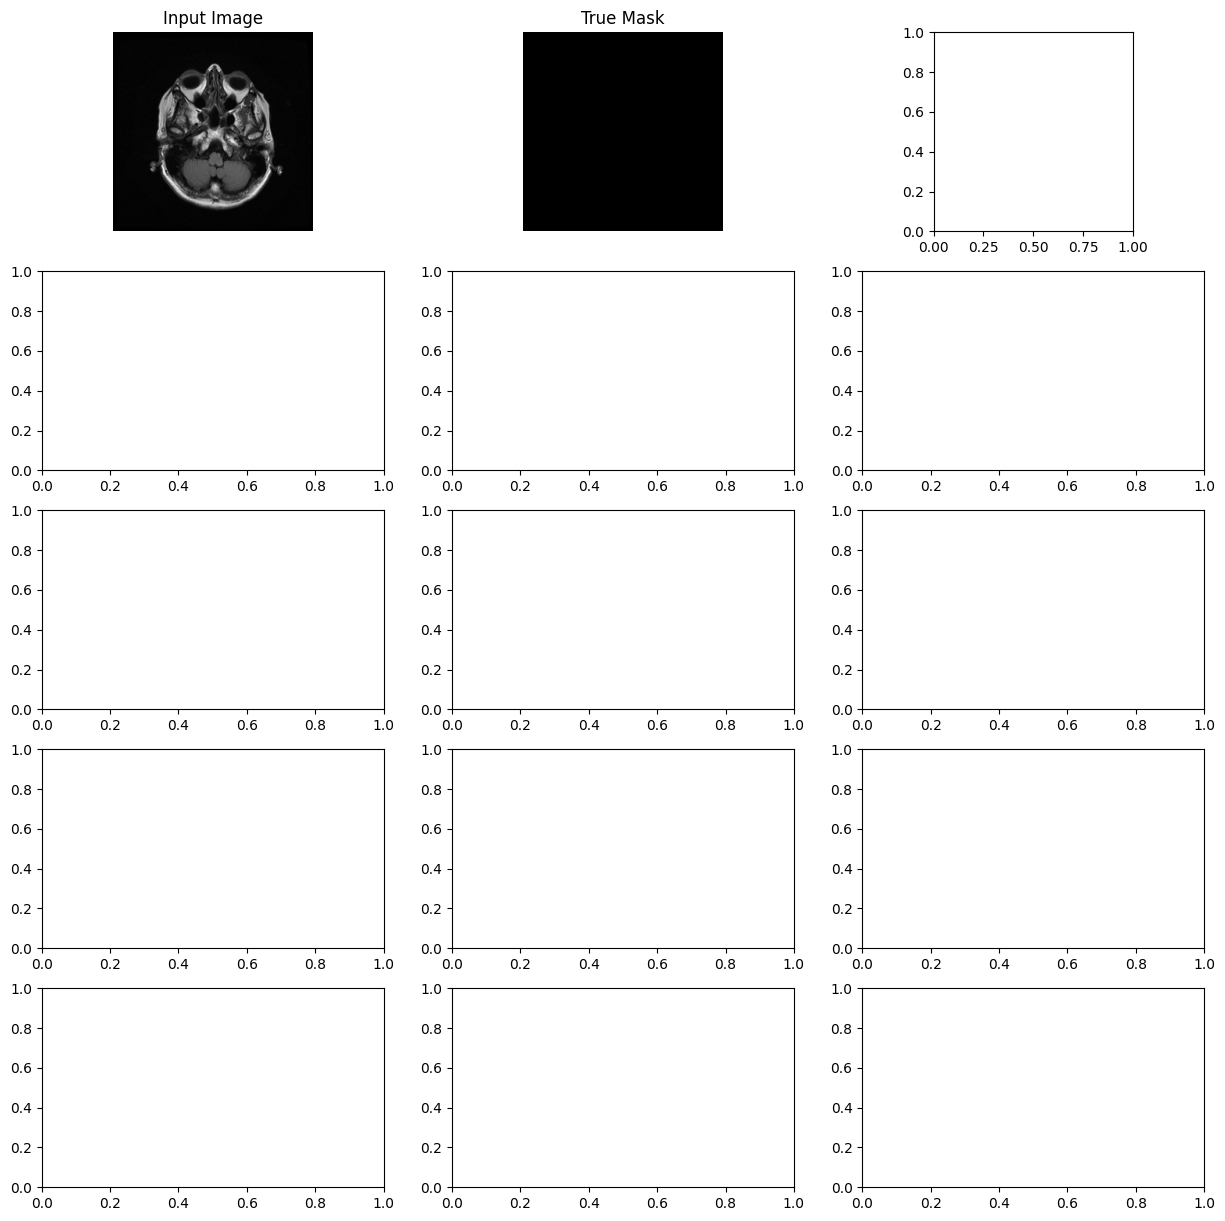

In [131]:
# Assuming params and test_images are defined
test_logits = unet_model.apply(params, test_images)
test_predictions = jnp.argmax(test_logits, axis=-1)
visualize_results(test_images, test_masks, test_predictions)

**6. Summary and Next Steps**

This notebook provides a foundation for building and training a U-Net model with JAX for image segmentation while emphasizing the importance of `jax.jit` for performance optimization. Remember to:

* Replace the placeholders in the code with appropriate JAX operations and functions based on your chosen dataset and architecture details.
* Experiment with different hyperparameters (learning rate, filters, etc.) and training strategies to improve the model's performance.
* Explore advanced techniques like data augmentation and regularization to enhance modelgeneralizability and robustness.

By completing this notebook and understanding the U-Net architecture, you can gain valuable practical experience in building and training deep learning models for image segmentation tasks using JAX effectively.